<h1>palAI & mAIs: Comparative Analysis of Machine
Learning Algorithms for Forecasting Palay and
Corn Production in Region VI (Western Visayas)</h1>

<h3>CMSC 197 Mini Project</h3>
<h4>AI Powered-Team (Manejo, Pajarilla, Vito)</h4>

<h3>Table of Contents</h3>

<ul>
    <li>Data Exploration</li>
    <li>Preprocessing</li>
    <li>Implementation of Machine Learning Algorithms
        <ul>
		<li>Linear Regression</li>
            <li>Random Forest Regression</li>
            <li>Support Vector Regression</li>
            <li> K-Nearest Neighbor (KNN)</li>
            <li>XGBoost</li>
            <li>Artificial Neural Network (ANN)</li>
        </ul>
    </li>
</ul>

<hr>
<h2> Preprocessing</h2>
<hr>

<h4> Importing Libraries </h4>

In [54]:
# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### machine learning algorithms ####
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

# for ANN
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam

# for preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#### metrics of evaluation ####
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### time series ###
from statsmodels.tsa.seasonal import seasonal_decompose

<h4> Load production volume and area harvested dataset </h4>

In [55]:
production_data = pd.read_csv('dataset/Production_volume.csv')
area_data = pd.read_csv('dataset/Area_harvested.csv')

In [56]:
production_data.head(5)

,Croptype,Province,Quarter 1 1987,Quarter 2 1987,Quarter 3 1987,Quarter 4 1987,Quarter 1 1988,Quarter 2 1988,Quarter 3 1988,Quarter 4 1988,...,Quarter 1 2022,Quarter 2 2022,Quarter 3 2022,Quarter 4 2022,Quarter 1 2023,Quarter 2 2023,Quarter 3 2023,Quarter 4 2023,Quarter 1 2024,Quarter 2 2024
0,Irrigated Palay,Aklan,19309,8971,7603,15727,23007,4255,16790,11766,...,21812.54,7994.02,12843.31,20642.70,17725.19,4504.00,8023.29,20508.02,16674.00,2113.00
1,NaN,Antique,28275,7440,8542,22786,24485,4366,13921,13356,...,48447.00,19146.00,68364.00,46723.97,49682.35,16465.82,47858.70,46714.90,44793.44,12032.20
2,NaN,Capiz,18540,805,406,21903,17872,0,18969,7314,...,32306.30,12063.00,34517.30,25112.06,34479.18,14151.29,26893.60,16226.75,34625.30,12522.75
3,NaN,Guimaras,0,0,0,0,0,0,0,0,...,4328.00,911.00,6036.00,5334.00,5139.00,1020.00,4047.00,6451.00,3837.00,344.00
4,NaN,Iloilo,58187,14743,6823,81600,81691,1256,57985,65076,...,148946.00,14692.00,144971.00,106234.00,155663.00,9195.87,130644.00,160041.35,149292.00,6048.66


In [57]:
area_data.head(5)

,Croptype,Province,Quarter 1 1987,Quarter 2 1987,Quarter 3 1987,Quarter 4 1987,Quarter 1 1988,Quarter 2 1988,Quarter 3 1988,Quarter 4 1988,...,Quarter 1 2022,Quarter 2 2022,Quarter 3 2022,Quarter 4 2022,Quarter 1 2023,Quarter 2 2023,Quarter 3 2023,Quarter 4 2023,Quarter 1 2024,Quarter 2 2024
0,Irrigated Palay,Aklan,6130,3440,2290,6890,7510,1610,6770,4440,...,6668.0,2461.18,4662,5832.77,6696.0,2171,3067,5940,6094,1138
1,NaN,Antique,9030,2430,2590,6350,9430,1620,4310,4770,...,12115.0,5903.00,15630,11325.00,12202.0,4452,10647,11220,12384,3506
2,NaN,Capiz,6300,520,100,5860,5830,0,4790,1940,...,9210.0,4508.00,8470,6704.00,9876.0,4648,6870,5000,9880,4143
3,NaN,Guimaras,0,0,0,0,0,0,0,0,...,1380.0,279.88,1534,1439.00,1330.0,350,1121,1821,1258,190
4,NaN,Iloilo,21270,6030,1850,23310,26270,440,16520,19140,...,41245.0,4235.00,41123,29142.00,42500.0,2658,38145,44625,43392,2124


<h4>Transforming and merging data</h4>

In [58]:
production_data = pd.melt(production_data,
                        id_vars=['Croptype', 'Province'],
                        var_name='Quarter and Year',
                        value_name='Production')

area_data = pd.melt(area_data,
                        id_vars=['Croptype', 'Province'],
                        var_name='Quarter and Year',
                        value_name='Area')

# fill values for croptype
production_data['Croptype'] = production_data['Croptype'].ffill()
area_data['Croptype'] = area_data['Croptype'].ffill()

dataset = pd.merge(production_data, area_data, on=['Croptype', 'Province', 'Quarter and Year'], how='left')

In [59]:
dataset.head(5)

,Croptype,Province,Quarter and Year,Production,Area
0,Irrigated Palay,Aklan,Quarter 1 1987,19309.0,6130.0
1,Irrigated Palay,Antique,Quarter 1 1987,28275.0,9030.0
2,Irrigated Palay,Capiz,Quarter 1 1987,18540.0,6300.0
3,Irrigated Palay,Guimaras,Quarter 1 1987,0.0,0.0
4,Irrigated Palay,Iloilo,Quarter 1 1987,58187.0,21270.0


In [60]:
# split year and quarter into separte columns
dataset['Year'] = dataset['Quarter and Year'].apply(lambda x: int(x.split(' ')[-1]))
dataset['Quarter'] = dataset['Quarter and Year'].apply(lambda x: int(x.split(' ')[1][-1]))

# drop 'Quarter and Year' column
dataset.drop(columns=['Quarter and Year'], inplace=True)

# reorder columns
dataset = dataset[['Croptype', 'Province', 'Quarter', 'Year', 'Area', 'Production']]

In [61]:
dataset.head(5)

,Croptype,Province,Quarter,Year,Area,Production
0,Irrigated Palay,Aklan,1,1987,6130.0,19309.0
1,Irrigated Palay,Antique,1,1987,9030.0,28275.0
2,Irrigated Palay,Capiz,1,1987,6300.0,18540.0
3,Irrigated Palay,Guimaras,1,1987,0.0,0.0
4,Irrigated Palay,Iloilo,1,1987,21270.0,58187.0


In [62]:
rows, columns = dataset.shape

# Print the number of rows
print("Number of rows:", rows)

Number of rows: 4500


<h4>Create Date column</h4>

In [63]:
quarter_to_month = {1: 1, 2: 4, 3: 7, 4: 10}

# Create the 'Date' column
dataset['Date'] = pd.to_datetime(dataset['Year'].astype(str) +
                                  dataset['Quarter'].map(quarter_to_month).astype(str) + '01',
                                  format='%Y%m%d')

# Reorder columns so 'Date' is the leftmost column
dataset = dataset[['Date'] + [col for col in dataset.columns if col != 'Date']]

In [64]:
dataset.head(5)

,Date,Croptype,Province,Quarter,Year,Area,Production
0,1987-10-01,Irrigated Palay,Aklan,1,1987,6130.0,19309.0
1,1987-10-01,Irrigated Palay,Antique,1,1987,9030.0,28275.0
2,1987-10-01,Irrigated Palay,Capiz,1,1987,6300.0,18540.0
3,1987-10-01,Irrigated Palay,Guimaras,1,1987,0.0,0.0
4,1987-10-01,Irrigated Palay,Iloilo,1,1987,21270.0,58187.0


Since Guimaras was included in Iloilo prior to 1994, we'll drop the data for those years to ensure accuracy.

In [65]:
dataset = dataset[~((dataset['Province'].isin(['Guimaras', 'Iloilo'])) & (dataset['Year'] <= 1994))]

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Quarter'}>],
       [<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Area'}>],
       [<Axes: title={'center': 'Production'}>, <Axes: >]], dtype=object)

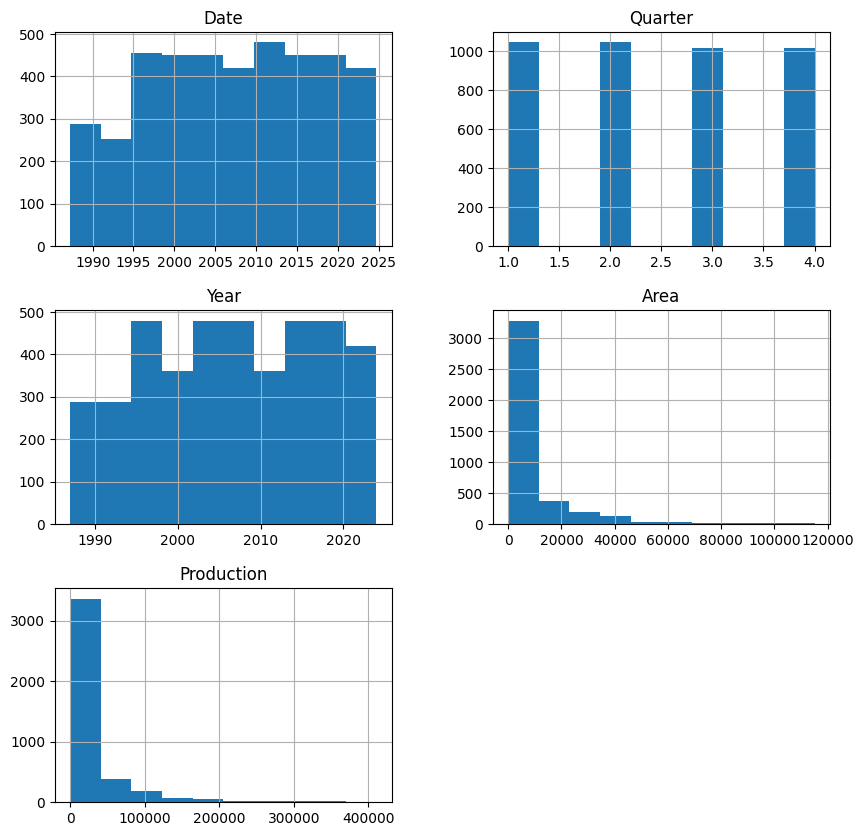

In [66]:
dataset.hist(figsize = (10, 10))

In [67]:
# descriptive statistics
desc_stats = dataset.describe()

print("Descriptive Statistics:")
desc_stats

Descriptive Statistics:


,Date,Quarter,Year,Area,Production
count,4116,4116.000000,4116.000000,4116.000000,4116.000000
mean,2007-03-11 01:11:22.215743488,2.485423,2006.629738,8365.982323,25329.648873
min,1987-04-01 00:00:00,1.000000,1987.000000,0.000000,0.000000
25%,1998-10-01 00:00:00,1.000000,1998.000000,179.750000,240.000000
50%,2007-07-01 00:00:00,2.000000,2007.000000,2137.500000,4992.500000
75%,2015-10-01 00:00:00,3.000000,2015.000000,8701.750000,26568.500000
max,2024-10-01 00:00:00,4.000000,2024.000000,115071.000000,411113.000000
std,NaN,1.118075,10.271357,15466.303607,49564.914948


In [68]:
# frequency distribution of categorical variables
print(dataset['Croptype'].value_counts())
print(dataset['Province'].value_counts())

Croptype
Irrigated Palay    686
Rainfed Palay      686
Palay              686
White Corn         686
Yellow Corn        686
Corn               686
Name: count, dtype: int64
Province
Aklan       900
Antique     900
Capiz       900
Guimaras    708
Iloilo      708
Name: count, dtype: int64


In [69]:
# check for zero values in the entire DataFrame
print((dataset == 0).sum())

Date            0
Croptype        0
Province        0
Quarter         0
Year            0
Area          153
Production    153
dtype: int64


Handling zero values. Using median since it is less sensitive to outliers.

In [70]:
# replace 0 with NaN
dataset.replace(0, np.nan, inplace=True)

# imputer = SimpleImputer(strategy='median')
# dataset[['Production', 'Area']] = imputer.fit_transform(dataset[['Production', 'Area']])

In [71]:
# drop rows that contains Nan
dataset = dataset.dropna()

In [72]:
rows, columns = dataset.shape

# Print the number of rows
print("Number of rows:", rows)

Number of rows: 3963


<b>Remove outliers.</b>

In [73]:
Q1 = dataset['Production'].quantile(0.25)
Q3 = dataset['Production'].quantile(0.75)
IQR = Q3 - Q1

In [74]:
dataset = dataset[(dataset['Production'] >= (Q1 - 1.5 * IQR)) & (dataset['Production'] <= (Q3 + 1.5 * IQR))]

In [75]:
rows, columns = dataset.shape

# Print the number of rows
print("Number of rows:", rows)

Number of rows: 3515


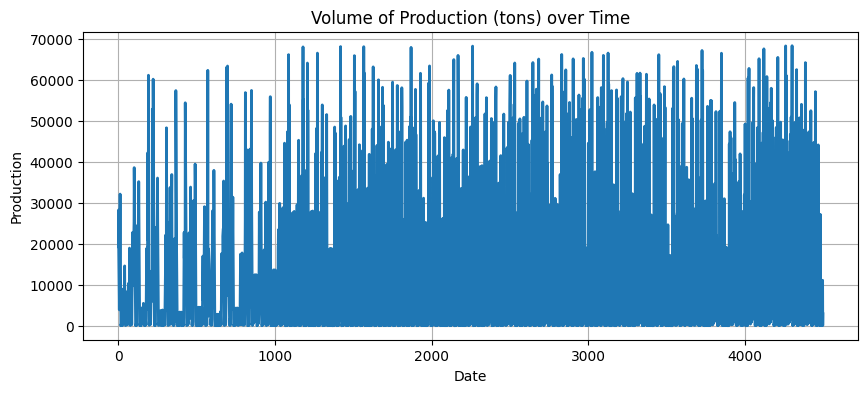

In [76]:
# visualizing the trend of 'Production' over time
plt.figure(figsize=(10, 4))
dataset['Production'].plot(title="Volume of Production (tons) over Time", linewidth=2)
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True)
plt.show()

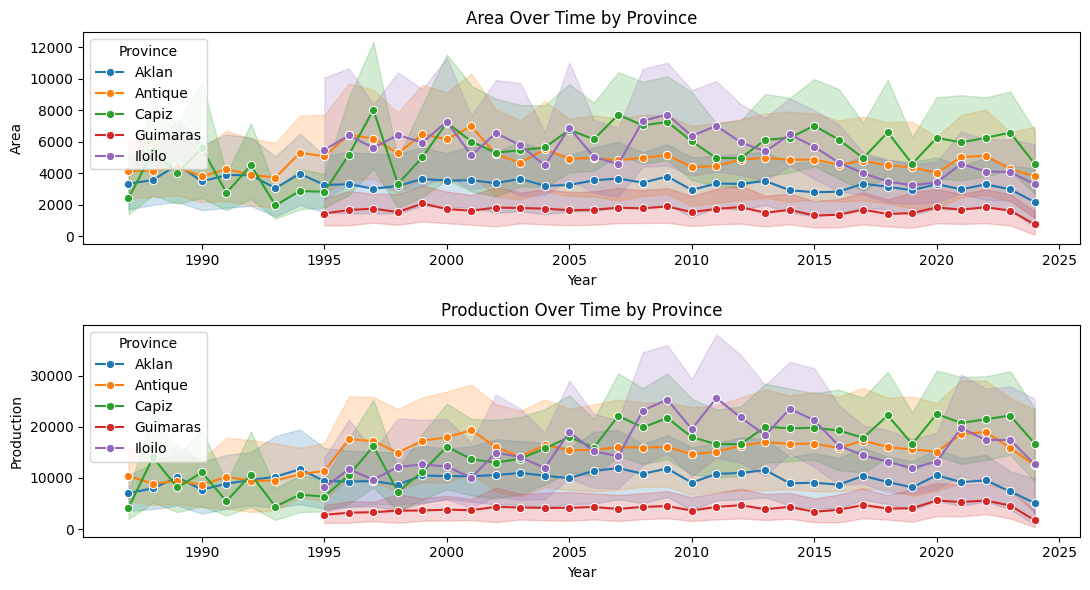

In [77]:
# plot Area and Production over time (Year)
plt.figure(figsize=(11, 6))

# plot Area over time
plt.subplot(2, 1, 1)
sns.lineplot(data=dataset, x='Year', y='Area', hue='Province', marker='o')
plt.title('Area Over Time by Province')
plt.xlabel('Year')
plt.ylabel('Area')

# plot Production over time
plt.subplot(2, 1, 2)
sns.lineplot(data=dataset, x='Year', y='Production', hue='Province', marker='o')
plt.title('Production Over Time by Province')
plt.xlabel('Year')
plt.ylabel('Production')

plt.tight_layout()
plt.show()

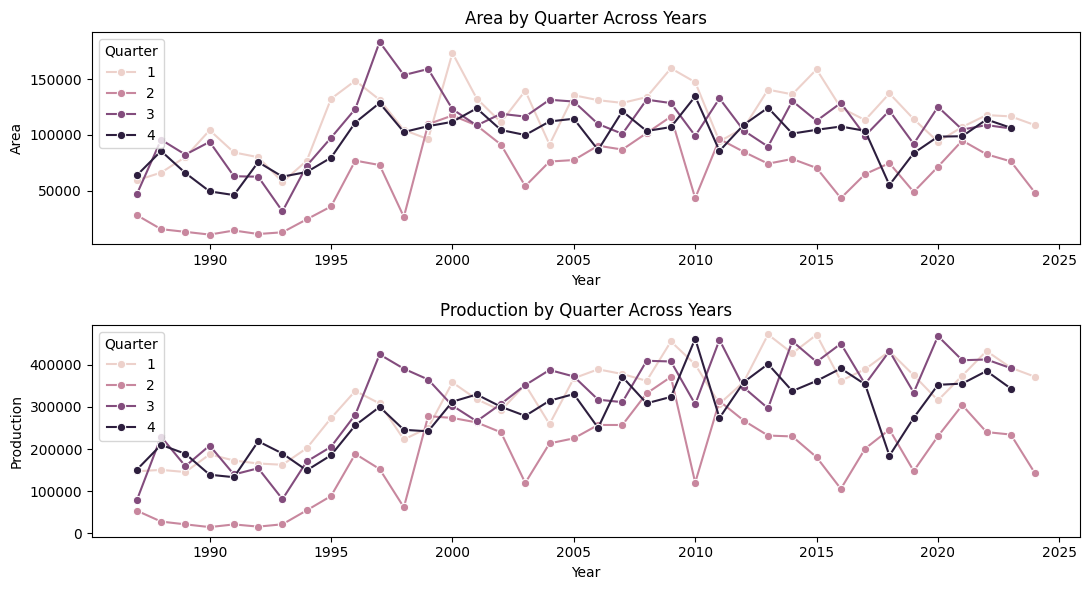

In [78]:
# aggregate data by Year and Quarter to see seasonal patterns
quarterly_data = dataset.groupby(['Year', 'Quarter'])[['Area', 'Production']].sum().reset_index()

# plot Area and Production for each quarter across the years
plt.figure(figsize=(11, 6))

# plot Area by Quarter
plt.subplot(2, 1, 1)
sns.lineplot(data=quarterly_data, x='Year', y='Area', hue='Quarter', marker='o')
plt.title('Area by Quarter Across Years')
plt.xlabel('Year')
plt.ylabel('Area')

# plot Production by Quarter
plt.subplot(2, 1, 2)
sns.lineplot(data=quarterly_data, x='Year', y='Production', hue='Quarter', marker='o')
plt.title('Production by Quarter Across Years')
plt.xlabel('Year')
plt.ylabel('Production')

plt.tight_layout()
plt.show()

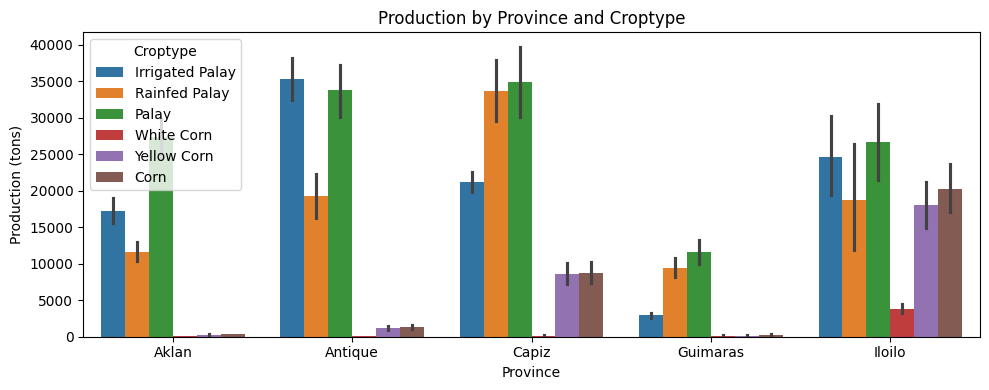

In [79]:
#\ visualizing production across Provinces with Croptype
plt.figure(figsize=(10, 4))

sns.barplot(x='Province', y='Production', hue='Croptype', data=dataset)

# adding titles and labels
plt.title('Production by Province and Croptype')
plt.xlabel('Province')
plt.ylabel('Production (tons)')

# Show the plot
plt.tight_layout()
plt.show()

                Area  Production   Quarter      Year
Area        1.000000    0.950185  0.015111 -0.024740
Production  0.950185    1.000000  0.037225  0.081674
Quarter     0.015111    0.037225  1.000000 -0.015977
Year       -0.024740    0.081674 -0.015977  1.000000


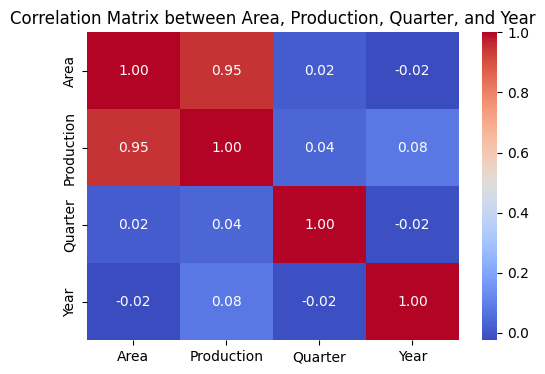

In [80]:
# calculate the correlation between Area and Production
corr = dataset[['Area', 'Production', 'Quarter', 'Year']].corr()
print(corr)

# visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Area, Production, Quarter, and Year')
plt.show()

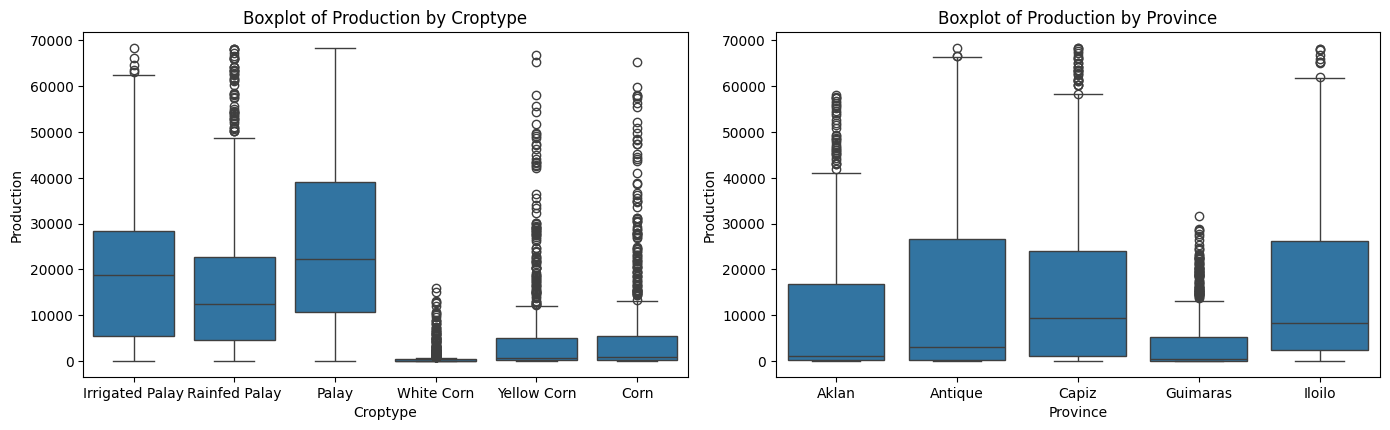

In [81]:
# Boxplot for Area and Production
plt.figure(figsize=(14, 8))

# Boxplot for Area
plt.subplot(2, 2, 1)
sns.boxplot(x='Croptype', y='Production', data=dataset)
plt.title('Boxplot of Production by Croptype')

# Boxplot for Production
plt.subplot(2, 2, 2)
sns.boxplot(x='Province', y='Production', data=dataset)
plt.title('Boxplot of Production by Province')

plt.tight_layout()
plt.show()

In [82]:
aggregated_data = dataset.groupby(['Croptype', 'Province', 'Quarter', 'Year']).agg(
    total_production=('Production', 'sum'),
    total_area=('Area', 'sum'),
).reset_index()

<h4> Feature Engineering</h4>

In [83]:
dataset = dataset.sort_values(by='Date', ascending=True)

In [84]:
# # Seasonal features
# dataset['Quarter_sin'] = np.sin(2 * np.pi * dataset['Quarter'] / 4)
# dataset['Quarter_cos'] = np.cos(2 * np.pi * dataset['Quarter'] / 4)

In [85]:
# # Create lag features
# dataset['Lag_1'] = dataset.groupby(['Province', 'Croptype', 'Quarter'])['Production'].shift(1)
# dataset['Lag_2'] = dataset.groupby(['Province', 'Croptype', 'Quarter'])['Production'].shift(2)
# dataset['Lag_3'] = dataset.groupby(['Province', 'Croptype', 'Quarter'])['Production'].shift(3)
# dataset['Lag_4'] = dataset.groupby(['Province', 'Croptype', 'Quarter'])['Production'].shift(4)

In [86]:
# # Create rolling mean features
# dataset['Rolling_Mean_1'] = dataset['Production'].rolling(window=2).mean()
# dataset['Rolling_Mean_4'] = dataset['Production'].rolling(window=4).mean()
# dataset['Rolling_Mean_2'] = dataset['Production'].rolling(window=2).mean()

In [87]:
dataset.head(5)

,Date,Croptype,Province,Quarter,Year,Area,Production
42,1987-04-01,Palay,Capiz,2,1987,2180.0,3385.0
47,1987-04-01,White Corn,Capiz,2,1987,70.0,51.0
46,1987-04-01,White Corn,Antique,2,1987,260.0,43.0
45,1987-04-01,White Corn,Aklan,2,1987,110.0,80.0
52,1987-04-01,Yellow Corn,Capiz,2,1987,240.0,292.0


In [88]:
# encoder = LabelEncoder()

# # Label encode Croptype and Province
# dataset['Croptype'] = encoder.fit_transform(dataset['Croptype'])
# dataset['Province'] = encoder.fit_transform(dataset['Province'])

encoding = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
encode_data = encoding.fit_transform(dataset[['Croptype', 'Province']])

dataset = pd.concat([dataset.reset_index(drop=True), encode_data.reset_index(drop=True)], axis=1)
dataset = dataset.drop(columns=['Croptype', 'Province'])

In [89]:
dataset['Log_Production'] = np.log(dataset['Production'] + 1)

In [90]:
dataset.head(5)

,Date,Quarter,Year,Area,Production,Croptype_Corn,Croptype_Irrigated Palay,Croptype_Palay,Croptype_Rainfed Palay,Croptype_White Corn,Croptype_Yellow Corn,Province_Aklan,Province_Antique,Province_Capiz,Province_Guimaras,Province_Iloilo,Log_Production
0,1987-04-01,2,1987,2180.0,3385.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.127405
1,1987-04-01,2,1987,70.0,51.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.951244
2,1987-04-01,2,1987,260.0,43.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.784190
3,1987-04-01,2,1987,110.0,80.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.394449
4,1987-04-01,2,1987,240.0,292.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.680173


<h4>Split train/test</h4>

In [91]:
# initialize the scaler
scaler = StandardScaler()

X = dataset.drop(['Production', 'Log_Production', 'Date'], axis=1)
y = dataset['Log_Production']

# pplit into train and test (70% train, 30% test)
train_size = int(0.7 * len(dataset))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# fit the scaler on the training data and transform X_train
X_train_scaled = scaler.fit_transform(X_train)

# transform X_test using the same scaler (do not fit again)
X_test_scaled = scaler.transform(X_test)

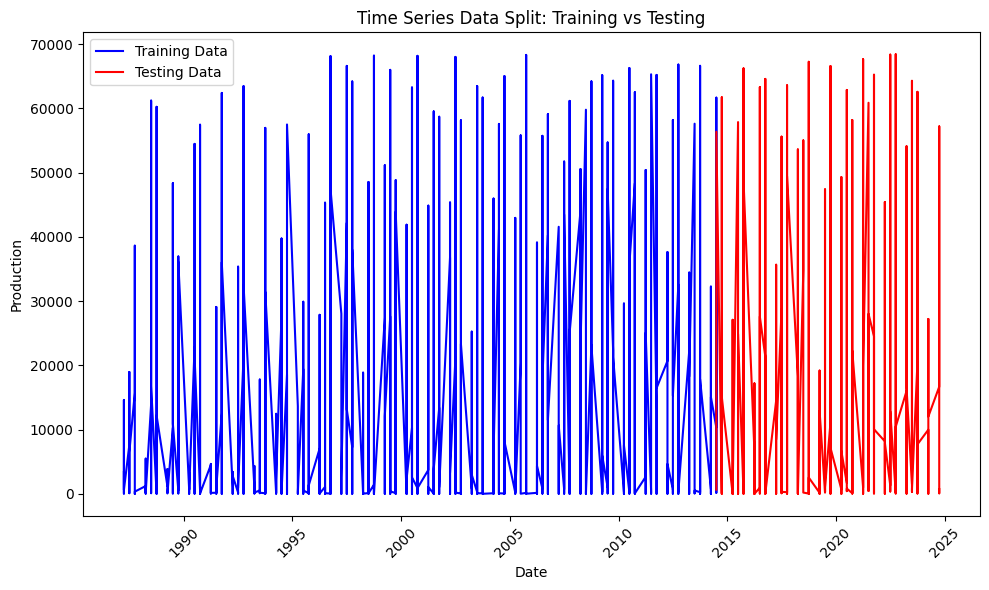

In [92]:
# Plotting the entire production data
plt.figure(figsize=(10, 6))

# Plot training data (first 70%)
plt.plot(dataset['Date'][:train_size], dataset['Production'][:train_size], label='Training Data', color='blue')

# Plot testing data (last 30%)
plt.plot(dataset['Date'][train_size:], dataset['Production'][train_size:], label='Testing Data', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Time Series Data Split: Training vs Testing')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()
plt.show()

<hr>
<h2> Implementing Machine Learning Algorithms</h2>
<hr>

<h4>Extreme Gradient Boosting (XGboost)</h4>

In [93]:
# perform gradientsearch

param_grid = {
     'learning_rate': [0.01, 0.1, 0.2],
     'max_depth': [3, 4, 5],
     'n_estimators': [100, 200, 500],
     'subsample': [0.8, 1.0],
     'reg_alpha': [0.01, 0.1, 0.2],
     'reg_lambda': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters found by GridSearchCV
print(grid_search.best_params_)

# Use the best model
model_xgb = grid_search.best_estimator_

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.1, 'subsample': 0.8}


In [94]:
# make predictions
y_pred = model_xgb.predict(X_test_scaled)

In [95]:
y_pred_original = np.exp(y_pred) - 1
y_test_original = np.exp(y_test) - 1

In [96]:
results = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred_original})
results.head(5)

,Actual,Predicted
2460,651.0,491.189789
2461,18904.0,18047.837891
2462,952.0,859.820801
2463,742.0,632.914368
2464,56358.0,54253.156250


In [97]:
# Calculate performance metrics on the test data
mae_train = mean_absolute_error(y_test_original, y_pred_original)
mse_train = mean_squared_error(y_test_original, y_pred_original)
r2_train = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original) * 100)

# Create a DataFrame to store the results
performance_xgb = pd.DataFrame({
    'Model': ['MAE', 'MSE', 'MAPE', 'R²'],
    'XG Boost': [mae_train, mse_train, mape, r2_train]
})

# Transpose to make the performance horizontal
performance_xgb = performance_xgb.set_index('Model').T

# Display the DataFrame
performance_xgb

Model,MAE,MSE,MAPE,R²
XG Boost,1649.387864,9.605676e+06,20.440721,0.965828


In [98]:
# import matplotlib.pyplot as plt

# # Plot feature importance
# xgb.plot_importance(model_xgb)
# plt.show()

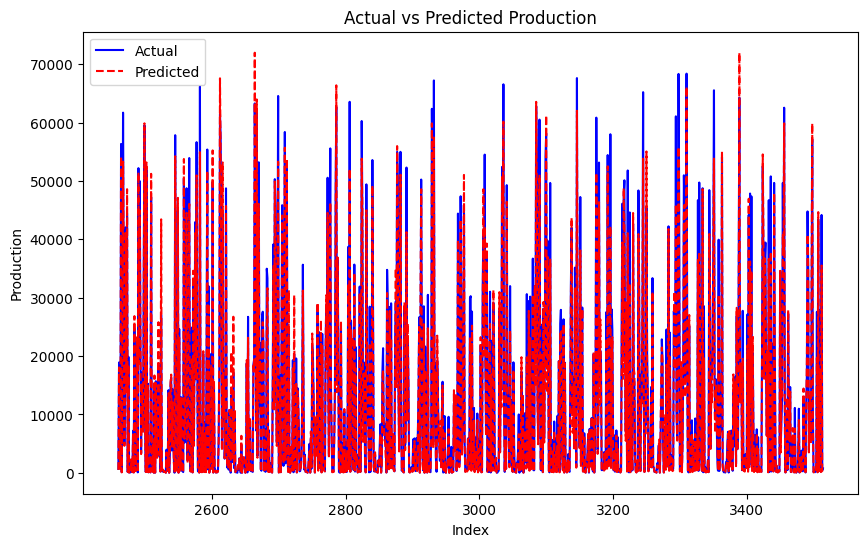

In [99]:
# 6. Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original.index, y_test_original, label='Actual', color='blue')
plt.plot(y_test_original.index, y_pred_original, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Production')
plt.legend()
plt.title('Actual vs Predicted Production')
plt.show()

<h4>Random Forest Regression</h4>

In [100]:
# model_rf = RandomForestRegressor(n_estimators=1000, max_features=4, random_state=1)
# model_rf.fit(X_train_scaled, y_train)

In [53]:
param_grid = {
     'n_estimators': [100, 200, 500],
     'max_depth': [3, 4, 5, 6],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4],
     'max_features': ['sqrt', 'log2', None, 0.5, 1.0],
     'bootstrap': [True, False]
}

# Perform Grid Search with RandomForestRegressor
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

# Best parameters found by GridSearchCV
print(grid_search_rf.best_params_)

# Use the best model
model_rf = grid_search_rf.best_estimator_

{'bootstrap': True, 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [101]:
# make predictions
y_pred = model_rf.predict(X_test_scaled)

In [102]:
y_pred_original = np.exp(y_pred) - 1
y_test_original = np.exp(y_test) - 1

In [103]:
results = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred_original})
results.head(5)

,Actual,Predicted
2460,651.0,431.028385
2461,18904.0,17808.564517
2462,952.0,721.252397
2463,742.0,780.526152
2464,56358.0,47965.480614


In [104]:
# Calculate performance metrics on the test data
mae_train = mean_absolute_error(y_test_original, y_pred_original)
mse_train = mean_squared_error(y_test_original, y_pred_original)
r2_train = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original) * 100)

# Create a DataFrame to store the results
performance_rf = pd.DataFrame({
    'Model': ['MAE', 'MSE', 'MAPE', 'R²'],
    'Random Forest': [mae_train, mse_train, mape, r2_train]
})

# Transpose to make the performance horizontal
performance_rf = performance_rf.set_index('Model').T

# Display the DataFrame
performance_rf

Model,MAE,MSE,MAPE,R²
Random Forest,2441.523012,2.240233e+07,27.516405,0.920305


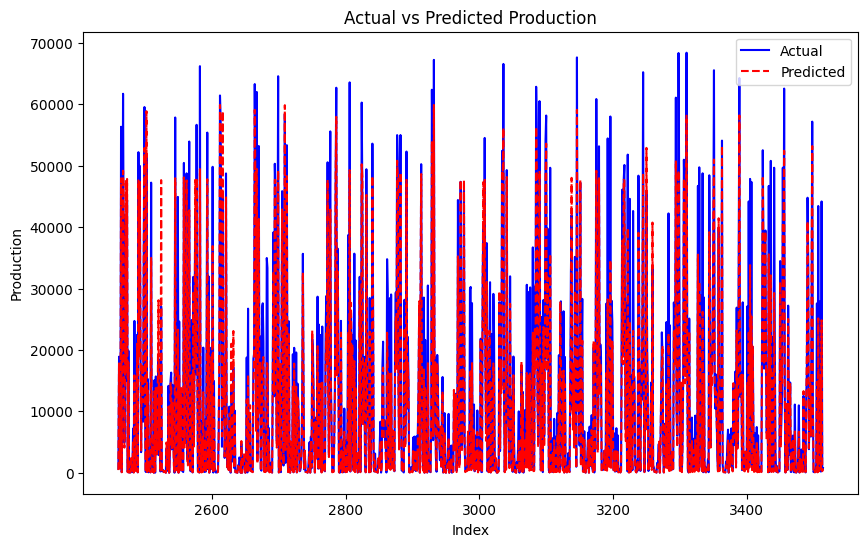

In [105]:
# 6. Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original.index, y_test_original, label='Actual', color='blue')
plt.plot(y_test_original.index, y_pred_original, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Production')
plt.legend()
plt.title('Actual vs Predicted Production')
plt.show()

<h4>Linear Regression</h4>

In [106]:
# from sklearn.linear_model import Ridge

# ridge = Ridge (alpha=1, solver='saga', tol=0.001)
# ridge.fit(X_train_scaled, y_train)

linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [107]:
# make predictions
y_pred = linear_model.predict(X_test_scaled)
# y_pred = ridge.predict(X_test_scaled)

In [108]:
y_pred_original = np.exp(y_pred) - 1
y_test_original = np.exp(y_test) - 1

In [109]:
results = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred_original})
results.head(5)

,Actual,Predicted
2460,651.0,397.751447
2461,18904.0,7559.874043
2462,952.0,723.164061
2463,742.0,305.038474
2464,56358.0,43900.290100


In [110]:
# Calculate performance metrics on the test data
mae_train = mean_absolute_error(y_test_original, y_pred_original)
mse_train = mean_squared_error(y_test_original, y_pred_original)
r2_train = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original) * 100)

# Create a DataFrame to store the results
performance_lr = pd.DataFrame({
    'Model': ['MAE', 'MSE', 'MAPE', 'R²'],
    'Linear Regression': [mae_train, mse_train, mape, r2_train]
})

# Transpose to make the performance horizontal
performance_lr = performance_lr.set_index('Model').T

# Display the DataFrame
performance_lr

Model,MAE,MSE,MAPE,R²
Linear Regression,16636.083652,4.964624e+09,301.91084,-16.661463


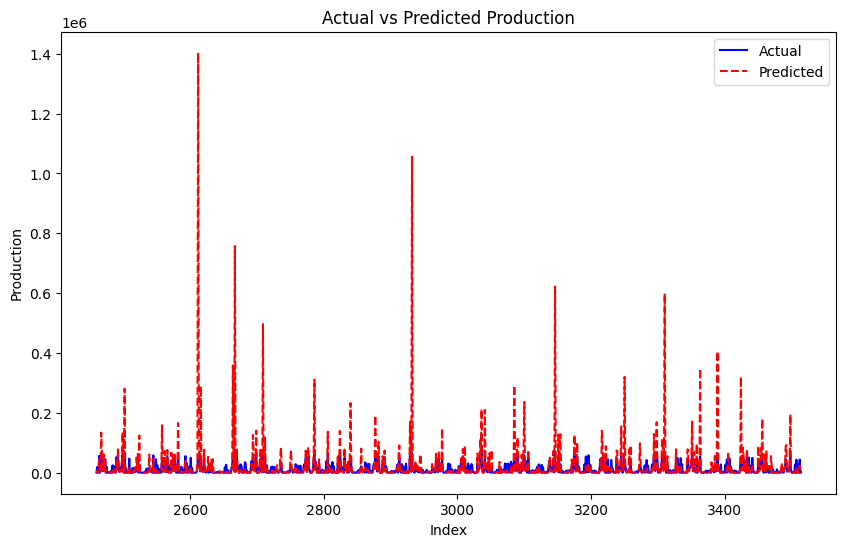

In [111]:
# 6. Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original.index, y_test_original, label='Actual', color='blue')
plt.plot(y_test_original.index, y_pred_original, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Production')
plt.legend()
plt.title('Actual vs Predicted Production')
plt.show()

<h4>K-Nearest Neighbor</h4>

In [141]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

# Best parameters found by GridSearchCV
print("Best Parameters:", grid_search_knn.best_params_)

# Use the best model
model_knn = grid_search_knn.best_estimator_

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}


In [142]:
# model_knn = KNeighborsRegressor(n_neighbors=20)
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [143]:
# make predictions
predictions = knn.predict(X_test)
y_pred = predictions

In [144]:
y_pred_original = np.exp(y_pred) - 1
y_test_original = np.exp(y_test) - 1

In [145]:
results = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred_original})
results.head(5)

,Actual,Predicted
2460,651.0,363.332847
2461,18904.0,21379.284729
2462,952.0,640.053182
2463,742.0,767.527693
2464,56358.0,44365.625646


In [146]:
# Calculate performance metrics on the test data
mae_train = mean_absolute_error(y_test_original, y_pred_original)
mse_train = mean_squared_error(y_test_original, y_pred_original)
r2_train = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original) * 100)

# Create a DataFrame to store the results
performance_knn = pd.DataFrame({
    'Model': ['MAE', 'MSE', 'MAPE', 'R²'],
    'K-Nearest Neighbor': [mae_train, mse_train, mape, r2_train]
})

# Transpose to make the performance horizontal
performance_knn = performance_knn.set_index('Model').T

# Display the DataFrame
performance_knn

Model,MAE,MSE,MAPE,R²
K-Nearest Neighbor,3220.527349,3.329849e+07,31.878054,0.881542


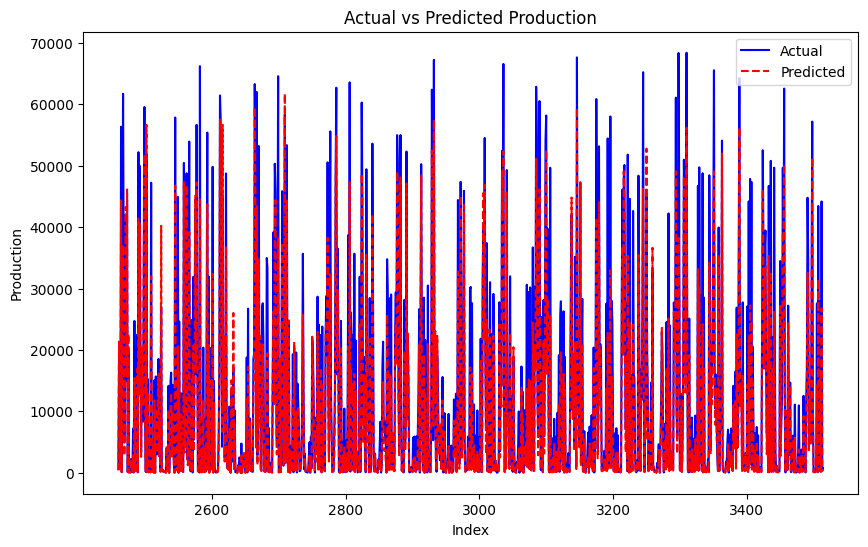

In [147]:
# 6. Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original.index, y_test_original, label='Actual', color='blue')
plt.plot(y_test_original.index, y_pred_original, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Production')
plt.legend()
plt.title('Actual vs Predicted Production')
plt.show()

<h4>Support Vector Regression</h4>

In [149]:
param_grid = {
     'C': [1, 10, 50, 100],
     'epsilon': [0.01, 0.1, 0.2, 0.5],
     'kernel': ['rbf', 'linear', 'poly']
}

# Create a GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(estimator=SVR(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameter combination found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Use the best model found by GridSearchCV
model_svr = grid_search.best_estimator_

KeyboardInterrupt: 

In [ ]:
# model_svr = SVR(kernel='rbf', C=100, epsilon=0.01)

# model_svr.fit(X_train, y_train)

In [ ]:
y_pred = model_svr.predict(X_test)

In [ ]:
y_pred_original = np.exp(y_pred) - 1
y_test_original = np.exp(y_test) - 1

In [ ]:
results = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred_original})
results.head(5)

In [ ]:
# Calculate performance metrics on the test data
mae_train = mean_absolute_error(y_test_original, y_pred_original)
mse_train = mean_squared_error(y_test_original, y_pred_original)
r2_train = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original) * 100)

# Create a DataFrame to store the results
performance_svr = pd.DataFrame({
    'Model': ['MAE', 'MSE', 'MAPE', 'R²'],
    'Support Vector Regression': [mae_train, mse_train, mape, r2_train]
})

# Transpose to make the performance horizontal
performance_svr = performance_svr.set_index('Model').T

# Display the DataFrame
performance_svr

In [ ]:
# 6. Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original.index, y_test_original, label='Actual', color='blue')
plt.plot(y_test_original.index, y_pred_original, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Production')
plt.legend()
plt.title('Actual vs Predicted Production')
plt.show()

<h4>Aritifical Neural Network</h4>

In [ ]:
# from tensorflow.keras.models import Sequential
# # Build the Artificial Neural Network (ANN) model
# model_ann = Sequential()

In [ ]:
# # Input layer (first hidden layer) with 64 neurons and ReLU activation
# model_ann.add(Dense(units=64, input_dim=X_train.shape[1], activation='relu'))

# # Add a second hidden layer with 32 neurons and ReLU activation
# model_ann.add(Dense(units=32, activation='relu'))

# # Output layer with 1 neuron (for regression task)
# model_ann.add(Dense(units=1))

# # Compile the model with Mean Squared Error loss function and Adam optimizer
# model_ann.compile(optimizer=Adam(), loss='mean_squared_error')

# # Fit the model on the training data (training the neural network)
# history = model_ann.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

In [ ]:
# y_pred = model_ann.predict(X_test)

In [ ]:
# y_pred_original = np.exp(y_pred) - 1
# y_test_original = np.exp(y_test) - 1

In [ ]:
# results = pd.DataFrame({'Actual': y_test_original, 'Predicted': y_pred_original})
# results.head(5)

In [ ]:
# # Calculate performance metrics on the test data
# mae_train = mean_absolute_error(y_test_original, y_pred_original)
# mse_train = mean_squared_error(y_test_original, y_pred_original)
# r2_train = r2_score(y_test_original, y_pred_original)
# mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original) * 100)

# # Create a DataFrame to store the results
# performance_ann = pd.DataFrame({
#     'Model': ['MAE', 'MSE', 'MAPE', 'R²'],
#     'Linear Regression': [mae_train, mse_train, mape, r2_train]
# })

# # Transpose to make the performance horizontal
# performance_ann = performance_ann.set_index('Model').T

# # Display the DataFrame
# performance_ann

In [ ]:
# # 6. Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_original.index, y_test_original, label='Actual', color='blue')
# plt.plot(y_test_original.index, y_pred_original, label='Predicted', color='red', linestyle='--')
# plt.xlabel('Index')
# plt.ylabel('Production')
# plt.legend()
# plt.title('Actual vs Predicted Production')
# plt.show()

<h4>Comparison of Model Performance</h4>

In [ ]:
merged_performance = pd.concat([performance_xgb, performance_rf, performance_lr, performance_svr, performance_knn], axis=0)

In [ ]:
merged_performance